In [2]:
import numpy as np
import librosa
import librosa.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import operator
# import OurSpectrogram


# import matlab.engine

In [3]:
mpl.rcParams['figure.dpi'] = 100

In [4]:
fs = 44100 # kHz
audio_path = 'songs/NationalAnthemIndia.mp3'
samples, fs = librosa.load(audio_path, sr=None, mono=False)
print(fs, samples.shape)

C:\Users\manas kumar mishra\AppData\Local\Programs\Python\Python39\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


44100 (2, 2292736)


(2292736,)


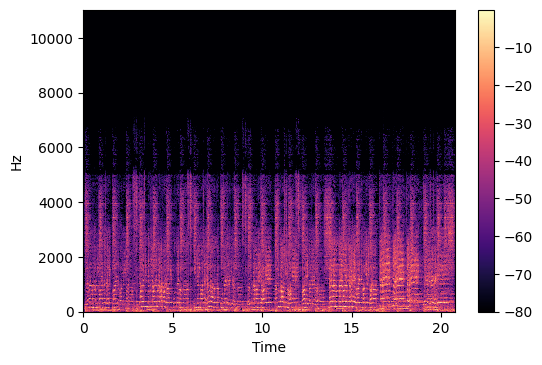

In [5]:
samples_mean = np.mean(samples, axis=0)
print(samples_mean.shape)
ft_samples = librosa.stft(samples_mean, window='hann', win_length=10240, n_fft=10240)
mag_samples_db = librosa.amplitude_to_db(np.abs(ft_samples), ref=np.max)
plt.figure()
librosa.display.specshow(mag_samples_db, y_axis='linear', x_axis='time')
plt.colorbar()
plt.show()

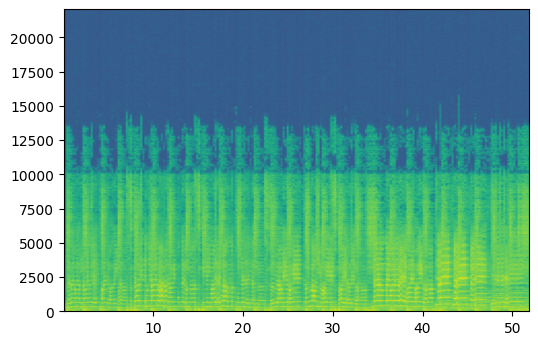

In [103]:
nfft = 10240
ptt, freq, time, im = mpl.pyplot.specgram(samples_mean, NFFT=nfft, Fs= fs, noverlap=None)



In [7]:
print(freq)
print(freq.shape)

print(time.shape)
lenTime = time.shape[0]
print(lenTime)



# print(FMat)
# print(TMat)

[0.00000000e+00 4.30664062e+00 8.61328125e+00 ... 2.20413867e+04
 2.20456934e+04 2.20500000e+04]
(5121,)
(226,)
226


In [118]:
a = []
a.append(1)
a.append(12)
a.append(13)
a.append(14)
b = []
b.append(2)
b.append(13)
b.append(20)
b.append(23)
c = []
c.append(1)
c.append(12)
c.append(11)
c.append(24)
d = []
d.append(2)
d.append(13)
d.append(29)
d.append(3)

# print(a)
# print(b)

FMat =[]
FMat.append(a)
FMat.append(b)
FMat.append(c)
FMat.append(d)
print(FMat)
print(FMat[1][0])

# for i in range(4):
#     print(FMat[i][i])

def columnVector(matrix, i):
    return [row[i] for row in matrix]

def maxIndex(array):
    MAX = array[0]
    index=0
    for i in range(1, len(array)):
        if(array[i]>MAX):
            index = i
    
    return index


tip = columnVector(FMat,2)
print(tip)
print(len(tip))
print(max(tip))
print(maxIndex(tip))

EnergyColumn = columnVector(ptt, 1)
print((EnergyColumn[0:2**(4)]))
for i in range(12):
    pos =0
    tempEnergy = EnergyColumn[pos:2**(i+1)+1]
    MaxEnergy = max(tempEnergy)
    Index = maxIndex(tempEnergy)
    print("Index: ", Index)
    pos = 2**(i+1)

# print(EnergyColumn)

[[1, 12, 13, 14], [2, 13, 20, 23], [1, 12, 11, 24], [2, 13, 29, 3]]
2
[13, 20, 11, 29]
4
29
3
[1.556591773224343e-06, 2.6321757878427456e-06, 5.317650905249933e-06, 1.332823741360146e-05, 3.446608369966782e-05, 0.0001345872063399047, 6.031981889472503e-05, 4.421621293129397e-05, 5.514428205948474e-05, 0.0008362477359445751, 0.0014446966372671805, 0.0014552924040472964, 0.0007545811405867949, 8.145766234020893e-05, 3.260577291756347e-05, 0.00010289768802153699]
Index:  2
Index:  4
Index:  8
Index:  16
Index:  32
Index:  64
Index:  127
Index:  234
Index:  487
Index:  937
Index:  1771
Index:  1771


In [169]:
FMat =[]
TMat =[]
EnergyOfPoint = []
FingerFreq =[]
FingerTime =[]

for step in range(lenTime):
    EnergyColumn = columnVector(ptt, step)
    pos =0
    # FingerFreq =[]
    # FingerTime =[]
    TimeOfCurrentWindow = time[step]
    for i in range(12):
        if(i+1 ==12):
            tempEnergy = EnergyColumn[pos:len(EnergyColumn)]
            MaxEnergy = max(tempEnergy)
            Index = maxIndex(tempEnergy)
            EnergyOfPoint.append(MaxEnergy)
            tempFreq = freq[pos:(2**(i+1)+1)]
            FingerFreq.append(tempFreq[Index])
            FingerTime.append(TimeOfCurrentWindow)
            # if(Index>-1 & Index <22051):
            #     FingerFreq.append(tempFreq[Index])
            #     FingerTime.append(TimeOfCurrentWindow)
            
        else:
            tempEnergy = EnergyColumn[pos:(2**(i+1)+1)]
            tempFreq = freq[pos:(2**(i+1)+1)]
            # print("length",len(tempEnergy))
            if(len(tempEnergy)>=0):
                MaxEnergy = max(tempEnergy)
                Index = maxIndex(tempEnergy)
                EnergyOfPoint.append(MaxEnergy)
                # print("Index : ",Index)
                # print("Frequency value",tempFreq[Index])
                FingerFreq.append(tempFreq[Index])
                FingerTime.append(TimeOfCurrentWindow)
                # if(Index >-1 & Index<22051):
                #     FingerFreq.append(tempFreq[Index])
                #     FingerTime.append(TimeOfCurrentWindow)
            
            
            pos = (2**(i+1))

        # print(FingerFreq)
    FMat.append(FingerFreq)
    TMat.append(FingerTime)
    # print(step)

# print("Frequency content", FMat)
# print("Time content", TMat)

In [171]:
# maximum value 

MaxEnergyTimeWindow = []

pos =0

for k in range(lenTime):
    EnergyColumn = EnergyOfPoint[pos:((12*k)+1)]
    # print(EnergyColumn)
    pos = 12*(k)
    MaxEnergyTimeWindow.append(max(EnergyColumn))

GlobalMaximum = max(MaxEnergyTimeWindow)
GlobalMaxIndex = maxIndex(MaxEnergyTimeWindow)

start =12*(GlobalMaxIndex-1)
MaxEnergyTimeWindow = EnergyOfPoint[start:start+13]

threshold = sum(MaxEnergyTimeWindow)/(len(MaxEnergyTimeWindow))
# print(threshold)

Alpha = 0.4

eta = Alpha*threshold

Fmat_final =[]
Tmat_final =[]
Ep_final   =[]

# print(len(EnergyOfPoint))
# print(len(FingerFreq))
for i in range(len(EnergyOfPoint)):
    if(EnergyOfPoint[i]>=eta):
        Ep_final.append(EnergyOfPoint[i])
        Fmat_final.append(FingerFreq[i])
        Tmat_final.append(FingerTime[i])

# print("Frequency vector", Fmat_final)
# print("Time vector ", Tmat_final)



2712
2712


In [172]:
fvector = np.array(Fmat_final)
tvector = np.array(Tmat_final)

# fvector = np.transpose(fvector)
# tvector = np.transpose(tvector)

FingerPrintMatrix = np.array((fvector, tvector))
# FingerPrintMatrix = np.transpose()

# FingerPrintMatrix = np.concatenate((fvector, tvector))
print(FingerPrintMatrix)
print(FingerPrintMatrix.shape)

[[1.72265625e+01 3.44531250e+01 6.89062500e+01 ... 1.24892578e+02
  2.58398438e+02 5.08183594e+02]
 [3.45396825e-01 3.45396825e-01 3.45396825e-01 ... 5.17079365e+01
  5.17079365e+01 5.17079365e+01]]
(2, 1157)
